<a href="https://colab.research.google.com/github/JairoMillapan/Tarea_2_IA/blob/main/2023_2_UOH_COM4402_Tarea_2_JairoMillapan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: Jairo Millapán

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Subir datasets de dígitos (train)

In [2]:
!wget https://github.com/JairoMillapan/Tarea_2_IA/raw/main/1_digits_train.txt

--2023-10-28 05:20:38--  https://github.com/JairoMillapan/Tarea_2_IA/raw/main/1_digits_train.txt
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JairoMillapan/Tarea_2_IA/main/1_digits_train.txt [following]
--2023-10-28 05:20:38--  https://raw.githubusercontent.com/JairoMillapan/Tarea_2_IA/main/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt’

1_digits_train.txt  100%[===================>] 625.59K  --.-KB/s    in 0.03s   

2023-10-28 05:20:38 (19.4 MB/s) - ‘1_digits_train.txt’ saved [640604/640604]



In [3]:
!wget https://github.com/JairoMillapan/Tarea_2_IA/raw/main/1_digits_test.txt

--2023-10-28 05:20:38--  https://github.com/JairoMillapan/Tarea_2_IA/raw/main/1_digits_test.txt
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JairoMillapan/Tarea_2_IA/main/1_digits_test.txt [following]
--2023-10-28 05:20:39--  https://raw.githubusercontent.com/JairoMillapan/Tarea_2_IA/main/1_digits_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187595 (183K) [text/plain]
Saving to: ‘1_digits_test.txt’

1_digits_test.txt   100%[===================>] 183.20K  --.-KB/s    in 0.02s   

2023-10-28 05:20:39 (7.34 MB/s) - ‘1_digits_test.txt’ saved [187595/187595]



## Leer dataset de dígitos

In [4]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [5]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,0,0,9,11,0,0,0,0,0,7,...,0,0,0,8,12,12,15,10,0,2
4343,0,0,6,15,2,0,0,0,0,0,...,0,0,0,7,16,16,10,1,0,6
4344,0,0,15,16,16,14,0,0,0,0,...,0,0,0,14,11,0,0,0,0,7
4345,0,0,0,1,15,11,0,0,0,0,...,0,0,0,0,1,16,10,0,0,4


In [6]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
1268,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
1269,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
1270,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


In [7]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

In [8]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

<ipython-input-8-9f48500b620a>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-8-9f48500b620a>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-8-9f48500b620a>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

In [9]:
df_train

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


## Crear modelo

In [10]:
model = nn.Sequential(
          nn.Linear(64, 10),
          nn.ReLU(),
          nn.Linear(10,10)
        )

In [11]:
device = torch.device('cuda')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Crear datasets y dataloaders para pytorch (train)

In [12]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [13]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Entrenamiento

In [14]:
batch_size = 128
patience = 10
max_epochs = 1000

#Función para cargar datos y crear dataloaders
def create_dataloader(df, batch_size=128):
    feats = df.iloc[:, :64].to_numpy().astype(np.float32)
    labels = df.iloc[:, 64].astype(int)
    dataset = [{"features": feats[i, :], "labels": labels.iloc[i]} for i in range(len(feats))]
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    return dataloader

#Función para entrenar y evaluar el modelo
def train_and_evaluate(model, dataloader_train, dataloader_val, patience=10, max_epochs=1000): #Como parámetros recibe el modelo de la red neuronal, los dataloaders de entrenamiento y validación
#el parámetro patience para evitar el overfitting y el número de épocas
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Preparamos el modelo para moverlo a gpu
    model = model.to(device) #Movemos el modelo para ejecutarlo en gpu

    criterion = nn.CrossEntropyLoss() #Línea que permite controlar la pérdida
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #Línea que permite optimizar el funcionamiento del código

    best_validation_loss = float('inf') #Registra el mejor valor de pérdida de validación
    epochs_without_improvement = 0 #Cuenta las cantidades de épocas sin mejora

    loss_train = [] #Arreglo para guardar la pérdida del entrenamiento
    loss_val = [] #Arreglo para guardar la pérdida de validación
    epochs = [] #Arreglo que guarda las épocas

    start = time.time() #Comenzamos el contador para saber cuánto demora el entrenamiento

    for epoch in range(max_epochs): #Creamos un ciclo, que se repetirá hasta las 1000 épocas
        loss_train_batches = [] #Arreglo para guardar las pérdidas de entrenamiento
        loss_val_batches = [] #Arreglo para guardar las pérdidas de validación

        model.train() #Con esta línea, nuestro modelo de red neuronal está en modo entrenamiento

        for i, data in enumerate(dataloader_train, 0): #En este recorremos los datos de entrenamiento,
        #se mueven los datos y etiquetas, se calcula la pérdida, se realiza la retropropagación y se actualizan los pesos del modelo.
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train_batches.append(loss.item())

        loss_train.append(np.mean(loss_train_batches)) #Guardamos los valores de pérdida de entrenamiento de cada época

        model.eval() #Colocamos el modelo en modo evaluación

        with torch.no_grad():
            for i, data in enumerate(dataloader_val, 0): #En este bucle recorremos los datos de validación y se calcula la pérdida de validación.
                inputs = data["features"].to(device)
                labels = data["labels"].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss_val_batches.append(loss.item())

        loss_val.append(np.mean(loss_val_batches)) #Guardamos los valores de pérdida de validación de cada época
        epochs.append(epoch) #Guardamos las épocas ejecutadas

        print("Epoch: %d, train loss: %.4f, val loss: %.4f" % (epoch, loss_train[epoch], loss_val[epoch])) #Imprimimos el número de cada época, la pérdida de entrenamiento de esa época y la pérdida de
        #validación de esa época

        #Condicionales creadas con el fin de evitar el overfitting, las condiciones son, si no hay mejora en la pérdida de validación se deja de ejecutar el código
        if loss_val[epoch] < best_validation_loss: #si es menor la pérdida de validación a la mejor pérdida de validación
            best_validation_loss = loss_val[epoch] #se convertirá en la nueva mejor pérdida
            torch.save(model.state_dict(), 'best_model_checkpoint.pth') #guardamos
            epochs_without_improvement = 0 #no hay épocas sin mejora
        else:
            epochs_without_improvement += 1 #sino, agregamos 1

        if epochs_without_improvement >= patience: #cuando las épocas sin mejora superan a 10
            break #termina de ejecutarse el entrenamiento

    end = time.time() #terminamos el tiempo
    print('Finished Training, total time %f seconds' % (end - start)) #imprimimos el tiempo final de ejecución

    return loss_train, loss_val, epochs #retornamos

#Función para visualizar la pérdida
def plot_loss(epochs, loss_train, loss_val): #parámetros a  graficar
    plt.figure(figsize=(8, 5))
    plt.title('Loss train and val') #título del gráfico
    plt.xlabel('Epochs') #título del eje x
    plt.ylabel('Loss') #título del eje y
    plt.plot(epochs, loss_train, 'b', label='Train') #graficamos la curva de pérdida de entrenamiento
    plt.plot(epochs, loss_val, 'r', label='Val') #graficamos la curva de pérdida de validación
    plt.grid() #agregamos cuadrícula
    plt.legend() #agregamos leyenda para cada curva
    plt.show() #mostramos el gráfico

#Función para calcular y mostrar la matriz de confusión y la precisión normalizada
def evaluate_model(model, dataloader):
    model.eval() #ponemos el modelo en modo evaluación
    all_predictions = [] #arreglo para guardar las predicciones
    all_labels = [] #arreglo para guardar las etiquetas

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Preparamos el modelo para moverlo a gpu

    for i, data in enumerate(dataloader, 0): #bucle para calcular las predicciones con sus respectivas etiquetas
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(labels.cpu().numpy())

    confusion = confusion_matrix(all_labels, all_predictions, normalize='true') #generamos la matriz de confusión
    accuracy = accuracy_score(all_labels, all_predictions) #generamos la precisión

    disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_labels)) #mostramos la matriz
    disp = disp.plot(cmap="Blues", values_format='.2f') #mostramos la matriz

    print("Accuracy: ", accuracy) #imprimimos la precisión

# **A continuación, con nuestras funciones principales, las llamaremos en las siguientes celdas. Sin embargo, iremos cambiando el modelo de la red neuronal según lo solicitado**

# **10 neuronas, ReLU, 1000 épocas**

Epoch: 0, train loss: 2.2310, val loss: 2.1461
Epoch: 1, train loss: 2.0481, val loss: 1.9530
Epoch: 2, train loss: 1.8455, val loss: 1.7295
Epoch: 3, train loss: 1.6382, val loss: 1.5284
Epoch: 4, train loss: 1.4417, val loss: 1.3479
Epoch: 5, train loss: 1.2640, val loss: 1.1687
Epoch: 6, train loss: 1.1060, val loss: 1.0389
Epoch: 7, train loss: 0.9729, val loss: 0.9146
Epoch: 8, train loss: 0.8590, val loss: 0.8235
Epoch: 9, train loss: 0.7669, val loss: 0.7144
Epoch: 10, train loss: 0.6888, val loss: 0.6516
Epoch: 11, train loss: 0.6198, val loss: 0.5827
Epoch: 12, train loss: 0.5538, val loss: 0.5375
Epoch: 13, train loss: 0.4931, val loss: 0.4556
Epoch: 14, train loss: 0.4383, val loss: 0.4144
Epoch: 15, train loss: 0.3905, val loss: 0.3745
Epoch: 16, train loss: 0.3517, val loss: 0.3349
Epoch: 17, train loss: 0.3196, val loss: 0.3074
Epoch: 18, train loss: 0.2951, val loss: 0.2803
Epoch: 19, train loss: 0.2727, val loss: 0.2806
Epoch: 20, train loss: 0.2549, val loss: 0.2549
Ep

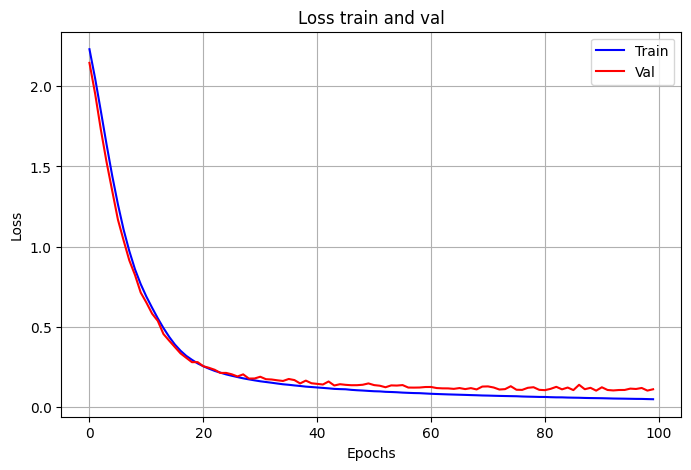

Accuracy:  0.9662835249042145


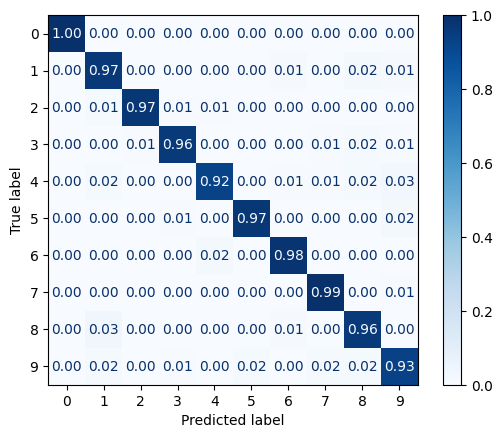

In [15]:
model1 = nn.Sequential(
    nn.Linear(64, 10),
    nn.ReLU(),
    nn.Linear(10, 10)
)
dataloader_train1 = create_dataloader(df_train, batch_size)
dataloader_val1 = create_dataloader(df_val, batch_size)
loss_train1, loss_val1, epochs1 = train_and_evaluate(model1, dataloader_train1, dataloader_val1, patience, max_epochs)
plot_loss(epochs1, loss_train1, loss_val1)
evaluate_model(model1, dataloader_val1)

# **40 neuronas, ReLU, 1000 épocas**

Epoch: 0, train loss: 2.1798, val loss: 1.9689
Epoch: 1, train loss: 1.7601, val loss: 1.5439
Epoch: 2, train loss: 1.3452, val loss: 1.1444
Epoch: 3, train loss: 0.9906, val loss: 0.8552
Epoch: 4, train loss: 0.7372, val loss: 0.6421
Epoch: 5, train loss: 0.5564, val loss: 0.5000
Epoch: 6, train loss: 0.4316, val loss: 0.3829
Epoch: 7, train loss: 0.3456, val loss: 0.3173
Epoch: 8, train loss: 0.2859, val loss: 0.2684
Epoch: 9, train loss: 0.2456, val loss: 0.2421
Epoch: 10, train loss: 0.2152, val loss: 0.2072
Epoch: 11, train loss: 0.1929, val loss: 0.1909
Epoch: 12, train loss: 0.1738, val loss: 0.1882
Epoch: 13, train loss: 0.1593, val loss: 0.1846
Epoch: 14, train loss: 0.1456, val loss: 0.1608
Epoch: 15, train loss: 0.1343, val loss: 0.1404
Epoch: 16, train loss: 0.1248, val loss: 0.1307
Epoch: 17, train loss: 0.1161, val loss: 0.1339
Epoch: 18, train loss: 0.1084, val loss: 0.1231
Epoch: 19, train loss: 0.1020, val loss: 0.1171
Epoch: 20, train loss: 0.0961, val loss: 0.1113
Ep

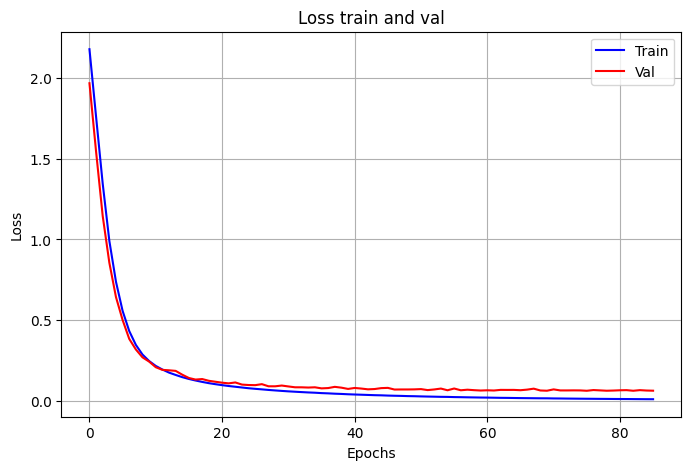

Accuracy:  0.9770114942528736


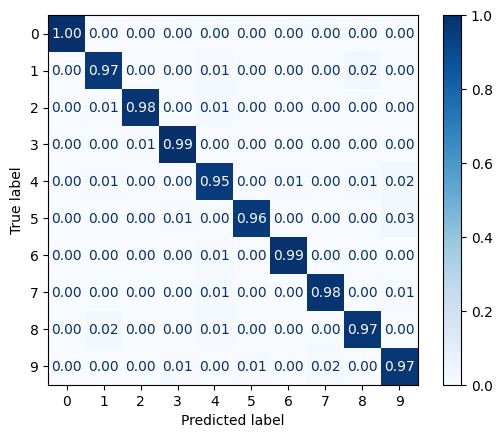

In [16]:
# Configuración 2: Red con activación Tanh
model2 = nn.Sequential(
    nn.Linear(64, 40),
    nn.ReLU(),
    nn.Linear(40, 10)
)
dataloader_train2 = create_dataloader(df_train, batch_size)
dataloader_val2 = create_dataloader(df_val, batch_size)
loss_train2, loss_val2, epochs2 = train_and_evaluate(model2, dataloader_train2, dataloader_val2, patience, max_epochs)
plot_loss(epochs2, loss_train2, loss_val2)
evaluate_model(model2, dataloader_val2)

In [17]:
# **10 neuronas, Tanh, 1000 épocas**

Epoch: 0, train loss: 2.1992, val loss: 2.0447
Epoch: 1, train loss: 1.9434, val loss: 1.8324
Epoch: 2, train loss: 1.7399, val loss: 1.6424
Epoch: 3, train loss: 1.5741, val loss: 1.4896
Epoch: 4, train loss: 1.4303, val loss: 1.3597
Epoch: 5, train loss: 1.3001, val loss: 1.2223
Epoch: 6, train loss: 1.1867, val loss: 1.1408
Epoch: 7, train loss: 1.0851, val loss: 1.0455
Epoch: 8, train loss: 0.9924, val loss: 0.9374
Epoch: 9, train loss: 0.9102, val loss: 0.8615
Epoch: 10, train loss: 0.8345, val loss: 0.7980
Epoch: 11, train loss: 0.7682, val loss: 0.7388
Epoch: 12, train loss: 0.7084, val loss: 0.6692
Epoch: 13, train loss: 0.6542, val loss: 0.6306
Epoch: 14, train loss: 0.6068, val loss: 0.5869
Epoch: 15, train loss: 0.5645, val loss: 0.5479
Epoch: 16, train loss: 0.5284, val loss: 0.5030
Epoch: 17, train loss: 0.4965, val loss: 0.4822
Epoch: 18, train loss: 0.4671, val loss: 0.4582
Epoch: 19, train loss: 0.4409, val loss: 0.4250
Epoch: 20, train loss: 0.4173, val loss: 0.4107
Ep

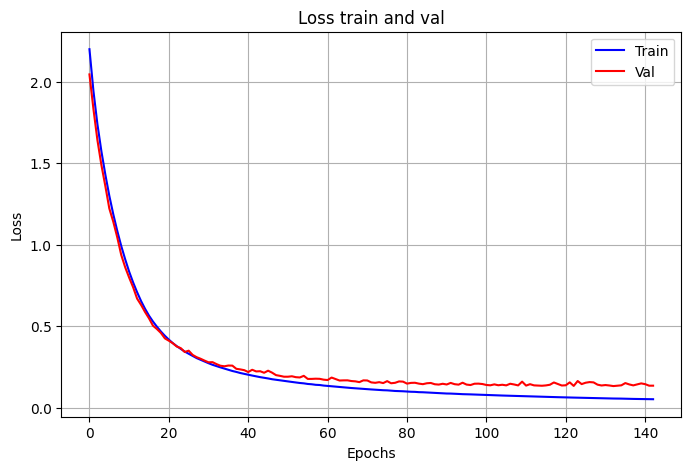

Accuracy:  0.960919540229885


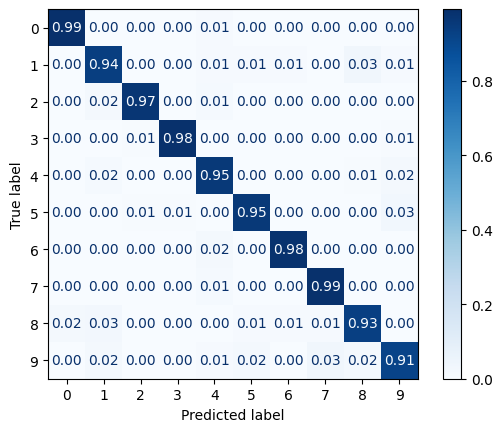

In [18]:
# Configuración 3: Red con activación Tanh
model3 = nn.Sequential(
    nn.Linear(64, 10),
    nn.Tanh(),
    nn.Linear(10, 10)
)
dataloader_train3 = create_dataloader(df_train, batch_size)
dataloader_val3 = create_dataloader(df_val, batch_size)
loss_train3, loss_val3, epochs3 = train_and_evaluate(model3, dataloader_train3, dataloader_val3, patience, max_epochs)
plot_loss(epochs3, loss_train3, loss_val3)
evaluate_model(model3, dataloader_val3)

# **40 neuronas, Tanh, 1000 épocas**

Epoch: 0, train loss: 2.0015, val loss: 1.6930
Epoch: 1, train loss: 1.4811, val loss: 1.2302
Epoch: 2, train loss: 1.0910, val loss: 0.9106
Epoch: 3, train loss: 0.8154, val loss: 0.6982
Epoch: 4, train loss: 0.6275, val loss: 0.5451
Epoch: 5, train loss: 0.4989, val loss: 0.4375
Epoch: 6, train loss: 0.4106, val loss: 0.3682
Epoch: 7, train loss: 0.3469, val loss: 0.3151
Epoch: 8, train loss: 0.3014, val loss: 0.2887
Epoch: 9, train loss: 0.2657, val loss: 0.2438
Epoch: 10, train loss: 0.2374, val loss: 0.2255
Epoch: 11, train loss: 0.2158, val loss: 0.2116
Epoch: 12, train loss: 0.1970, val loss: 0.1973
Epoch: 13, train loss: 0.1818, val loss: 0.1779
Epoch: 14, train loss: 0.1694, val loss: 0.1806
Epoch: 15, train loss: 0.1582, val loss: 0.1662
Epoch: 16, train loss: 0.1481, val loss: 0.1649
Epoch: 17, train loss: 0.1391, val loss: 0.1572
Epoch: 18, train loss: 0.1323, val loss: 0.1453
Epoch: 19, train loss: 0.1256, val loss: 0.1358
Epoch: 20, train loss: 0.1181, val loss: 0.1334
Ep

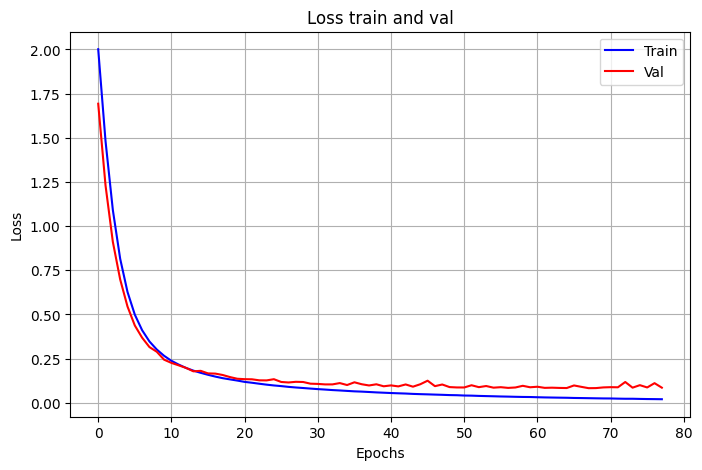

Accuracy:  0.9731800766283525


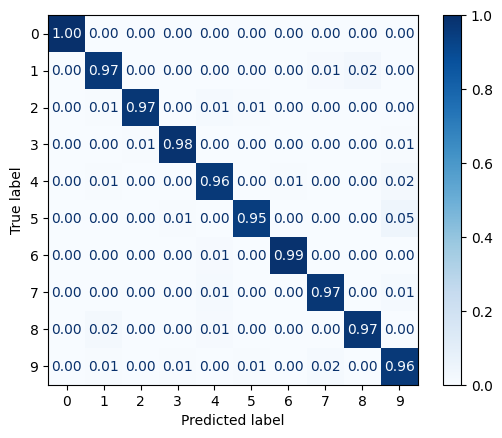

In [19]:
# Configuración 4: Red con activación Tanh
model4 = nn.Sequential(
    nn.Linear(64, 40),
    nn.Tanh(),
    nn.Linear(40, 10)
)
dataloader_train4 = create_dataloader(df_train, batch_size)
dataloader_val4 = create_dataloader(df_val, batch_size)
loss_train4, loss_val4, epochs4 = train_and_evaluate(model4, dataloader_train4, dataloader_val4, patience, max_epochs)
plot_loss(epochs4, loss_train4, loss_val4)
evaluate_model(model4, dataloader_val4)

# **2 capas de 10 neuronas, ReLU, 1000 épocas**

Epoch: 0, train loss: 2.2871, val loss: 2.2493
Epoch: 1, train loss: 2.1885, val loss: 2.1311
Epoch: 2, train loss: 2.0327, val loss: 1.9635
Epoch: 3, train loss: 1.8185, val loss: 1.7301
Epoch: 4, train loss: 1.5910, val loss: 1.5187
Epoch: 5, train loss: 1.3886, val loss: 1.3278
Epoch: 6, train loss: 1.2181, val loss: 1.1634
Epoch: 7, train loss: 1.0778, val loss: 1.0130
Epoch: 8, train loss: 0.9559, val loss: 0.9267
Epoch: 9, train loss: 0.8481, val loss: 0.8129
Epoch: 10, train loss: 0.7607, val loss: 0.7381
Epoch: 11, train loss: 0.6888, val loss: 0.6573
Epoch: 12, train loss: 0.6319, val loss: 0.6165
Epoch: 13, train loss: 0.5796, val loss: 0.5698
Epoch: 14, train loss: 0.5310, val loss: 0.5248
Epoch: 15, train loss: 0.4845, val loss: 0.4649
Epoch: 16, train loss: 0.4384, val loss: 0.4330
Epoch: 17, train loss: 0.3940, val loss: 0.3877
Epoch: 18, train loss: 0.3516, val loss: 0.3547
Epoch: 19, train loss: 0.3179, val loss: 0.3146
Epoch: 20, train loss: 0.2869, val loss: 0.2950
Ep

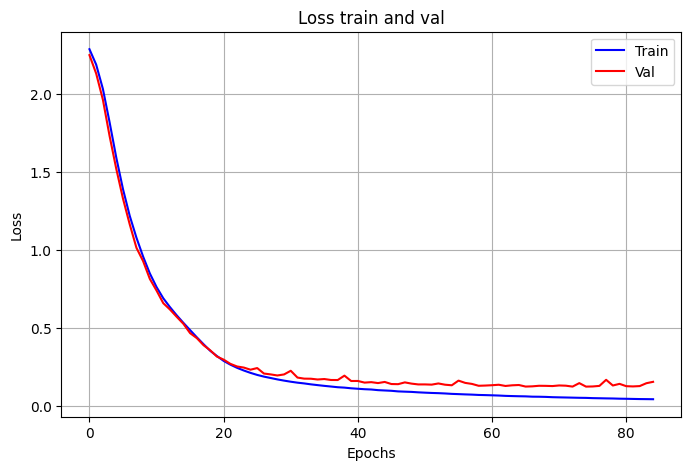

Accuracy:  0.9616858237547893


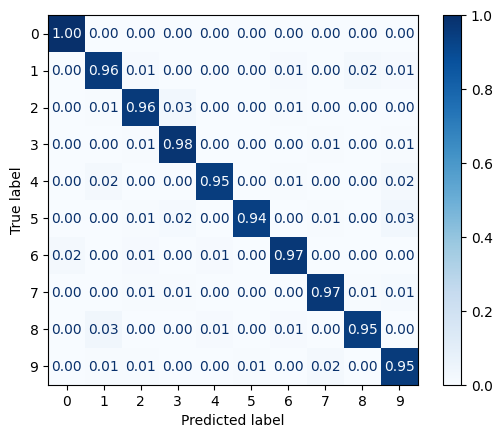

In [20]:
# Configuración 5: Red con activación Tanh
model5 = nn.Sequential(
    nn.Linear(64, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 10)
)
dataloader_train5 = create_dataloader(df_train, batch_size)
dataloader_val5 = create_dataloader(df_val, batch_size)
loss_train5, loss_val5, epochs5 = train_and_evaluate(model5, dataloader_train5, dataloader_val5, patience, max_epochs)
plot_loss(epochs5, loss_train5, loss_val5)
evaluate_model(model5, dataloader_val5)

# **2 capas de 40 neuronas, ReLU, 1000 épocas**

Epoch: 0, train loss: 2.2067, val loss: 2.0637
Epoch: 1, train loss: 1.8534, val loss: 1.5597
Epoch: 2, train loss: 1.2601, val loss: 0.9575
Epoch: 3, train loss: 0.7329, val loss: 0.5473
Epoch: 4, train loss: 0.4210, val loss: 0.3345
Epoch: 5, train loss: 0.2776, val loss: 0.2462
Epoch: 6, train loss: 0.2115, val loss: 0.2127
Epoch: 7, train loss: 0.1733, val loss: 0.1645
Epoch: 8, train loss: 0.1481, val loss: 0.1684
Epoch: 9, train loss: 0.1299, val loss: 0.1434
Epoch: 10, train loss: 0.1141, val loss: 0.1306
Epoch: 11, train loss: 0.1011, val loss: 0.1207
Epoch: 12, train loss: 0.0911, val loss: 0.1200
Epoch: 13, train loss: 0.0816, val loss: 0.1059
Epoch: 14, train loss: 0.0747, val loss: 0.1008
Epoch: 15, train loss: 0.0674, val loss: 0.1014
Epoch: 16, train loss: 0.0625, val loss: 0.0973
Epoch: 17, train loss: 0.0570, val loss: 0.0893
Epoch: 18, train loss: 0.0523, val loss: 0.0882
Epoch: 19, train loss: 0.0482, val loss: 0.0932
Epoch: 20, train loss: 0.0445, val loss: 0.0981
Ep

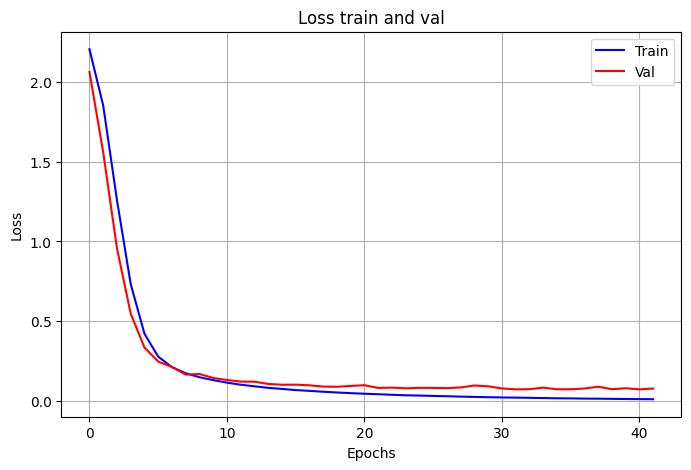

Accuracy:  0.9754789272030652


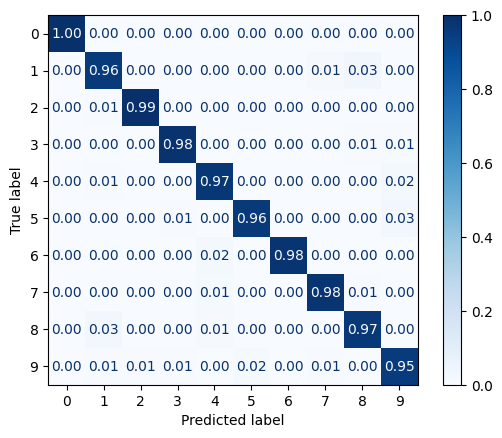

In [21]:
model6 = nn.Sequential(
    nn.Linear(64, 40),
    nn.ReLU(),
    nn.Linear(40, 40),
    nn.ReLU(),
    nn.Linear(40, 10)
)
dataloader_train6 = create_dataloader(df_train, batch_size)
dataloader_val6 = create_dataloader(df_val, batch_size)
loss_train6, loss_val6, epochs6 = train_and_evaluate(model6, dataloader_train6, dataloader_val6, patience, max_epochs)
plot_loss(epochs6, loss_train6, loss_val6)
evaluate_model(model6, dataloader_val6)